### Dataset description


The dataset comprises 4000 images of handwritten numbers.

In [1]:
import os
from os import listdir
from os.path import isfile, join, splitext

train_dir = 'train'
# Read all file names from train directory
train_files = [f for f in listdir(train_dir) if isfile(join(train_dir, f))]

valid_dir = 'valid'
# Read all file names from validation directory
valid_files = [f for f in listdir(valid_dir) if isfile(join(valid_dir, f))]

test_dir = 'test'
# Read all file names from test directory
test_files = [f for f in listdir(test_dir) if isfile(join(test_dir, f))]
print(len(train_files), len(valid_files), len(test_files))

2000 1000 1000


In [2]:
from skimage import io
import numpy as np
from sklearn.preprocessing import OneHotEncoder

# Returns images and their labels
def get_imgs(files, file_dir):
    encoder = OneHotEncoder(sparse=False)
    img_list = []
    img_labels = []
    for file in files:
        filepath = join(file_dir, file)
        img = io.imread(filepath)
        img = np.expand_dims(img, axis=2)
        img_list.append(img)
        img_labels.append(int(file[10]))
    img_labels = np.asarray(img_labels)
    img_labels = encoder.fit_transform(img_labels.reshape(-1, 1))
    img_list = np.asarray(img_list)
    return img_list, img_labels

train_imgs, train_labels = get_imgs(train_files, train_dir)
valid_imgs, valid_labels = get_imgs(valid_files, valid_dir)
test_imgs, test_labels = get_imgs(test_files, test_dir)

print(train_imgs.shape, train_labels.shape)

(2000, 28, 28, 1) (2000, 10)


In [3]:
import keras
from keras.layers import Conv2D, MaxPooling2D, Dropout
from keras.layers import Flatten, Dense
from keras.models import Sequential

# Returns compiled model
def get_model(input_shape, class_count):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(class_count, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='adam', metrics=['accuracy'])
    
    return model

from keras.callbacks import Callback

# Custom callback class for keeping train-loss and valid-loss
class CustomCallback(Callback):
    def on_train_begin(self, logs={}):
        self.train_loss = []
        self.val_loss = []
        
    def on_epoch_end(self, epoch, logs={}):
        self.train_loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))

custom_callback = CustomCallback()

from keras.preprocessing.image import ImageDataGenerator

# Create augmentation data generator
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1)

model = get_model(train_imgs[0].shape, train_labels[0].shape[0])

datagen.fit(train_imgs)

epochs = 9

model.fit_generator(datagen.flow(train_imgs, train_labels,
                                 batch_size=32, shuffle=True),
                    steps_per_epoch=int(train_imgs.shape[0] / 32),
                    epochs=epochs,
                    validation_data=(valid_imgs, valid_labels),
                    callbacks = [custom_callback])


Using TensorFlow backend.
c:\users\user\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\user\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\user\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/9
62/62 [==============================] - 1s 23ms/step - loss: 1.6893 - acc: 0.4168 - val_loss: 3.8090 - val_acc: 0.7510
Epoch 2/9
62/62 [==============================] - 1s 17ms/step - loss: 0.8679 - acc: 0.7228 - val_loss: 1.5744 - val_acc: 0.8970
Epoch 3/9
62/62 [==============================] - 2s 25ms/step - loss: 0.6218 - acc: 0.8065 - val_loss: 1.4929 - val_acc: 0.9020
Epoch 4/9
62/62 [==============================] - 2s 27ms/step - loss: 0.4661 - acc: 0.8604 - val_loss: 1.6853 - val_acc: 0.8900
Epoch 5/9
62/62 [==============================] - 2s 27ms/step - loss: 0.4149 - acc: 0.8674 - val_loss: 1.4138 - val_acc: 0.9090
Epoch 6/9
62/62 [==============================] - 2s 27ms/step - loss: 0.3782 - acc: 0.8821 - val_loss: 1.4122 - v

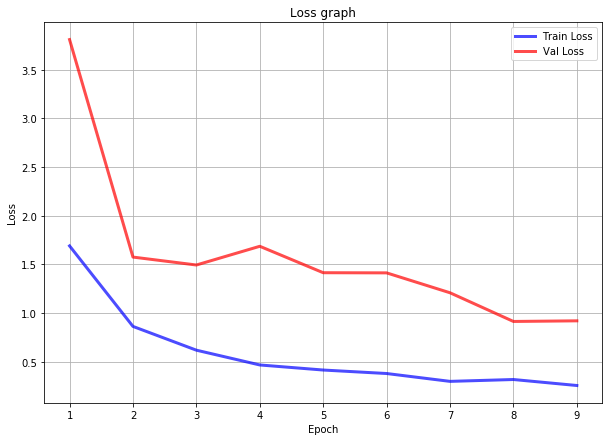

In [4]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
%matplotlib inline
import itertools

def loss_graph(epochs, train_loss, val_loss):
    x_axis = np.linspace(1, epochs, num=epochs)
    
    plt.figure(figsize=(10, 7))
    plt.plot(x_axis, train_loss, color='b', lw=3, alpha=0.7, label='Train Loss')
    plt.plot(x_axis, val_loss, color='r', lw=3, alpha=0.7, label='Val Loss')
    plt.title('Loss graph')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)

loss_graph(epochs, custom_callback.train_loss, custom_callback.val_loss)

Accuracy: 0.944
Precision: 0.944
Recall: 0.944


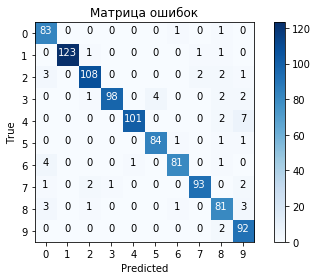

In [5]:
def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Матрица ошибок')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.tight_layout()


predictions = model.predict(test_imgs)

test_labels_labeled = np.argmax(test_labels, axis=1)
predictions_labeled = np.argmax(predictions, axis=1)

acc = accuracy_score(test_labels_labeled, predictions_labeled)
# 'micro' calculates metrics globally by counting the total true positives, false negatives and false positives.
prec = precision_score(test_labels_labeled, predictions_labeled, average='micro')
rec = recall_score(test_labels_labeled, predictions_labeled, average='micro')

print('Accuracy:', acc)
print('Precision:', prec)
print('Recall:', rec)

cm = confusion_matrix(test_labels_labeled, predictions_labeled)
plot_confusion_matrix(cm, ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

### Conclusion

We have implemented a convolutional neural network for hand written numbers classification. We have tried 3 different configurations with different number of neurons in different layers.
Results:

32 64 64

    Accuracy: 0.944
    Precision: 0.944
    Recall: 0.944
    
16 32 32

    Accuracy: 0.914
    Precision: 0.914
    Recall: 0.914
    
8 16 16

    Accuracy: 0.852
    Precision: 0.852
    Recall: 0.852
    
The best result was shown the network with the biggest number of neurons in each layer.    